In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 5.5 MB/s eta 0:00:00


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from xgboost import XGBClassifier

from wordcloud import WordCloud,STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

import re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [40]:
df = pd.read_csv('data.csv')

In [41]:
def perform_eda(df):
    """
    Perform Exploratory Data Analysis (EDA) on financial sentiment analysis data.

    Parameters:
    df (DataFrame): The dataframe containing the data.

    Returns:
    None
    """
    # Display the shape of the dataframe
    print('\nShape of the dataframe:', df.shape, '\n')

    # Print the head of the dataframe
    print("Head of the dataframe:")
    print(df.head())

    # Print general information about the dataframe
    print("\nInformation of the dataframe:")
    print(df.info())

    # Print summary statistics of the numerical columns of the dataframe
    print("\nSummary statistics of the numerical columns:")
    print(df.describe())

    # Print a countplot of Sentiment
    plt.figure(figsize=(8, 6))
    sns.countplot(x='Sentiment', data=df)
    plt.title('Distribution of Sentiments')
    plt.show()



def tweet_len(tweet):
    """
    Calculate the length of a tweet after removing stopwords.

    Args:
    tweet (str): The input tweet.

    Returns:
    int: The length of the tweet after removing stopwords.
    """
    # Remove non-alphabetic characters
    letters_only = re.sub('[^a-zA-Z]', ' ', tweet)

    # Convert to lowercase and split into words
    words = letters_only.lower().split()

    # Get the set of English stopwords
    stops = set(stopwords.words('english'))

    # Filter out stopwords
    meaningful_words = [w for w in words if w not in stops]

    # Return the length of meaningful words
    return len(meaningful_words)

def tweet_to_words(tweet):
    """
    Convert a tweet to a string of meaningful words (excluding stopwords).

    Args:
    tweet (str): The input tweet.

    Returns:
    str: A string containing meaningful words.
    """
    # Remove non-alphabetic characters
    letters_only = re.sub('[^a-zA-Z]', ' ', tweet)

    # Convert to lowercase and split into words
    words = letters_only.lower().split()

    # Get the set of English stopwords
    stops = set(stopwords.words('english'))

    # Filter out stopwords
    meaningful_words = [w for w in words if w not in stops]

    # Join the meaningful words back into a single string
    return ' '.join(meaningful_words)


Shape of the dataframe: (5842, 2) 

Head of the dataframe:
                                            Sentence Sentiment
0  The GeoSolutions technology will leverage Bene...  positive
1  $ESI on lows, down $1.50 to $2.50 BK a real po...  negative
2  For the last quarter of 2010 , Componenta 's n...  positive
3  According to the Finnish-Russian Chamber of Co...   neutral
4  The Swedish buyout firm has sold its remaining...   neutral

Information of the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB
None

Summary statistics of the numerical columns:
                                                 Sentence Sentiment
count                                                5842      5842
unique                                   

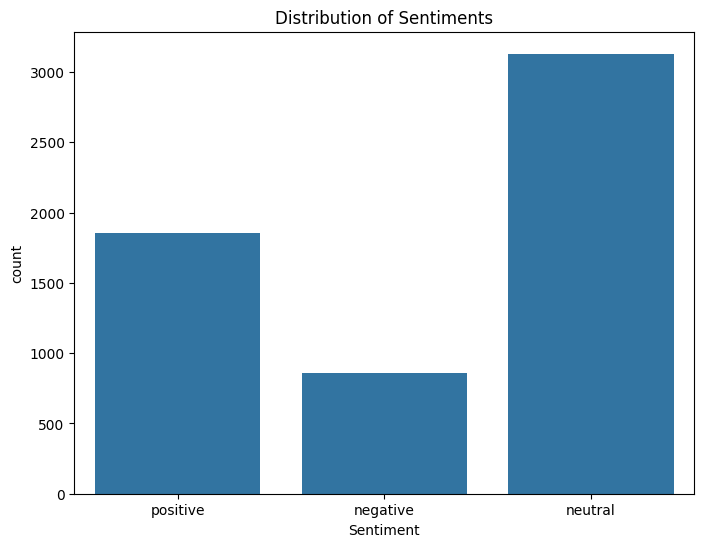

In [42]:
# Perform EDA
perform_eda(df)

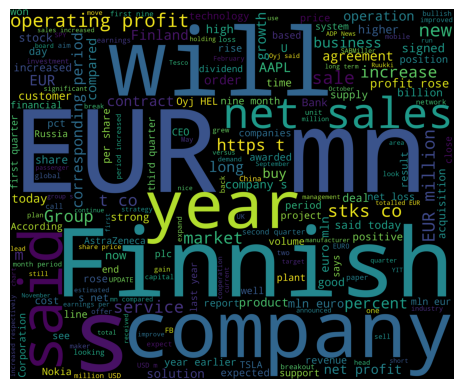

In [43]:
# Sentiment Positive
df1 = df[df['Sentiment']=='positive']
words = ' '.join(df1['Sentence'].astype(str))
cleaned_word = ' '.join([word for word in words.split() if not word.startswith('@')])

wordcloud = WordCloud(background_color='black',stopwords=STOPWORDS,
                      width=3000, height=2500).generate(''.join(cleaned_word))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

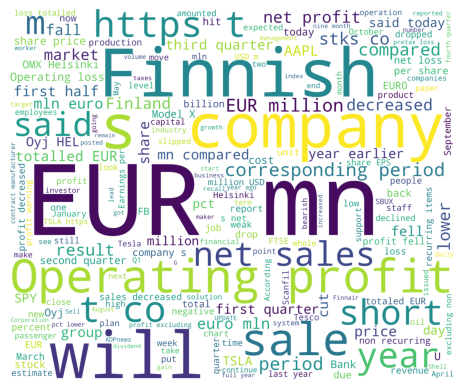

In [44]:
# Sentiment Negative

df2 = df[df['Sentiment']=='negative']
words = ' '.join(df2['Sentence'].astype(str))
cleaned_word = ' '.join([word for word in words.split() if not word.startswith('@')])

wordcloud = WordCloud(background_color='white',stopwords=STOPWORDS,
                      width=3000, height=2500).generate(''.join(cleaned_word))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

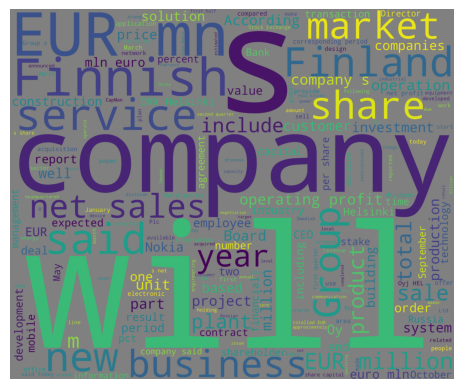

In [45]:
# Sentiment Neutral

df3 = df[df['Sentiment']=='neutral']
words = ' '.join(df3['Sentence'].astype(str))
cleaned_word = ' '.join([word for word in words.split() if not word.startswith('@')])

wordcloud = WordCloud(background_color='gray',stopwords=STOPWORDS,
                      width=3000, height=2500).generate(''.join(cleaned_word))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [46]:
#Count information per category
plot1=df.groupby(by=["Sentence","Sentiment"]).count().reset_index()
plot1

,Sentence,Sentiment
0,"#Apple breaks major support, here are some lev...",negative
1,#Apple up almost 20% from its February lows wi...,positive
2,#Fintech provider $CAFN Cachet Financial Solut...,positive
3,#FusionIQ NEW Positive Timing Signal on $SBUX ...,positive
4,#LongPos $TSLA 256 Break-out thru 50 & 200- DM...,positive
...,...,...
5831,volatility squeeze in $AAPL. I hope it gets re...,neutral
5832,what #stocks large players are selling http://...,negative
5833,what is up with $HK..... from Jan to now it's ...,negative
5834,www.countryelements.co.uk Designed by Patricia...,neutral


In [47]:
# Preprocessing steps:
# - 'Sentiments': Assigns 0 for 'negative' sentiment and 1 for other sentiments.
# - 'clean_tweet': Applies 'tweet_to_words' function to clean and process the tweet text.
# - 'tweet_length': Calculates the length of the cleaned tweet.

df['Sentiments'] = df['Sentiment'].apply(lambda x: 0 if x=='negative' else 1)
df['clean_tweet'] = df['Sentence'].astype(str).apply(lambda x: tweet_to_words(x))
df['tweet_length'] = df['Sentence'].astype(str).apply(lambda x: tweet_len(x))

# Splitting the data into training and testing sets:
# - train_data: 80% of the data for training.
# - test_data: 20% of the data for testing.
# - Random seed of 123 for reproducibility.

train_data, test_data = train_test_split(df, test_size=0.2, random_state=123)

In [48]:
# Extracting cleaned tweets for training and testing data:
# - train_clean_tweet: List containing cleaned tweets from the training data.
# - test_clean_tweet: List containing cleaned tweets from the testing data.

train_clean_tweet = []
for tweet in train_data['clean_tweet']:
    train_clean_tweet.append(tweet)

test_clean_tweet = []
for tweet in test_data['clean_tweet']:
    test_clean_tweet.append(tweet)

In [49]:
# Using CountVectorizer to convert text data into a matrix of token counts:

from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
v = CountVectorizer(analyzer='word')

# Convert cleaned tweets into feature vectors
train_features = v.fit_transform(train_clean_tweet)
test_features = v.transform(test_clean_tweet)

In [50]:
#To build our Models

# List of Classifiers with Different Algorithms:

Classifiers = [
    LogisticRegression(C=0.000000001,solver='liblinear',max_iter=200),
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),

]

In [51]:
# Model Training and Evaluation

 # Initialize lists to store model names and their respective metrics
Metrics = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-score': []}


# Iterate through each classifier
for classifier in Classifiers:
    # Train the classifier
    classifier.fit(train_features, train_data['Sentiments'])

    # Make predictions
    pred = classifier.predict(test_features)

    # Calculate evaluation metrics
    accuracy = accuracy_score(test_data['Sentiments'], pred)
    precision = precision_score(test_data['Sentiments'], pred)
    recall = recall_score(test_data['Sentiments'], pred)
    f1 = f1_score(test_data['Sentiments'], pred)

    # Append metrics to the dictionary
    Metrics['Model'].append(classifier.__class__.__name__)
    Metrics['Accuracy'].append(accuracy)
    Metrics['Precision'].append(precision)
    Metrics['Recall'].append(recall)
    Metrics['F1-score'].append(f1)

# Displaying the metrics
metrics_df = pd.DataFrame(Metrics)
print(metrics_df)




                    Model  Accuracy  Precision    Recall  F1-score
0      LogisticRegression  0.853721   0.853721  1.000000  0.921089
1    KNeighborsClassifier  0.823781   0.858696  0.949900  0.901998
2  DecisionTreeClassifier  0.741660   0.853659  0.841683  0.847629


///  Ensemble
//Stacking
//Bagging
//Boosting
//Voting  
1 function each


/// Optimization on classiifer
//  msg on teams



In [52]:
from sklearn.ensemble import StackingClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier

def get_stacking_classifier(base_classifiers):
    return StackingClassifier(estimators=base_classifiers, final_estimator=LogisticRegression())

def get_bagging_classifier(base_classifier):
    return BaggingClassifier(base_estimator=base_classifier, n_estimators=10, random_state=123)

def get_boosting_classifier(base_classifier):
    return AdaBoostClassifier(base_estimator=base_classifier, n_estimators=50, learning_rate=1.0)

def get_voting_classifier(base_classifiers):
    return VotingClassifier(estimators=base_classifiers, voting='hard')

# Define base classifiers
base_classifiers = [
    ('Logistic Regression', LogisticRegression(C=0.000000001, solver='liblinear', max_iter=200)),
    ('KNN', KNeighborsClassifier(3)),
    ('Decision Tree', DecisionTreeClassifier())
]

# Get ensemble classifiers
stacking_classifier = get_stacking_classifier(base_classifiers)
bagging_classifier = get_bagging_classifier(DecisionTreeClassifier())
boosting_classifier = get_boosting_classifier(DecisionTreeClassifier())
voting_classifier = get_voting_classifier(base_classifiers)



In [53]:
#checking accuracy of ensemble classifiers
# Train ensemble classifiers
stacking_classifier.fit(train_features, train_data['Sentiments'])
bagging_classifier.fit(train_features, train_data['Sentiments'])
boosting_classifier.fit(train_features, train_data['Sentiments'])
voting_classifier.fit(train_features, train_data['Sentiments'])

# Make predictions
stacking_pred = stacking_classifier.predict(test_features)
bagging_pred = bagging_classifier.predict(test_features)
boosting_pred = boosting_classifier.predict(test_features)
voting_pred = voting_classifier.predict(test_features)

# Evaluate ensemble classifiers
stacking_accuracy = accuracy_score(test_data['Sentiments'], stacking_pred)
bagging_accuracy = accuracy_score(test_data['Sentiments'], bagging_pred)
boosting_accuracy = accuracy_score(test_data['Sentiments'], boosting_pred)
voting_accuracy = accuracy_score(test_data['Sentiments'], voting_pred)

# Display the output
print("Stacking Classifier Accuracy:", stacking_accuracy)
print("Bagging Classifier Accuracy:", bagging_accuracy)
print("Boosting Classifier Accuracy:", boosting_accuracy)
print("Voting Classifier Accuracy:", voting_accuracy)


Stacking Classifier Accuracy: 0.853721129170231
Bagging Classifier Accuracy: 0.7715996578272027
Boosting Classifier Accuracy: 0.7801539777587682
Voting Classifier Accuracy: 0.8246364414029085


In [54]:
# Displaying the metrics
print("Metrics for Individual Classifiers:")
print(metrics_df)

# Display the comparison of accuracies
print("\nComparison of Accuracies:")
print("Logistic Regression Accuracy:", metrics_df.loc[metrics_df['Model'] == 'LogisticRegression', 'Accuracy'].values[0])
print("KNN Accuracy:", metrics_df.loc[metrics_df['Model'] == 'KNeighborsClassifier', 'Accuracy'].values[0])
print("Decision Tree Accuracy:", metrics_df.loc[metrics_df['Model'] == 'DecisionTreeClassifier', 'Accuracy'].values[0])

print("\nEnsemble Classifier Accuracies:")
print("Stacking Classifier Accuracy:", stacking_accuracy)
print("Bagging Classifier Accuracy:", bagging_accuracy)
print("Boosting Classifier Accuracy:", boosting_accuracy)
print("Voting Classifier Accuracy:", voting_accuracy)

Metrics for Individual Classifiers:
                    Model  Accuracy  Precision    Recall  F1-score
0      LogisticRegression  0.853721   0.853721  1.000000  0.921089
1    KNeighborsClassifier  0.823781   0.858696  0.949900  0.901998
2  DecisionTreeClassifier  0.741660   0.853659  0.841683  0.847629

Comparison of Accuracies:
Logistic Regression Accuracy: 0.853721129170231
KNN Accuracy: 0.823781009409752
Decision Tree Accuracy: 0.7416595380667237

Ensemble Classifier Accuracies:
Stacking Classifier Accuracy: 0.853721129170231
Bagging Classifier Accuracy: 0.7715996578272027
Boosting Classifier Accuracy: 0.7801539777587682
Voting Classifier Accuracy: 0.8246364414029085


In [129]:
#Optimization on logistic regression
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [100, 200, 300]
}

# Initialize the classifier
logistic_regression = LogisticRegression()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform GridSearchCV
grid_search.fit(train_features, train_data['Sentiments'])

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)


Best Parameters: {'C': 0.001, 'max_iter': 100, 'solver': 'liblinear'}
Best Score: 0.8525573406314054


In [156]:
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
import itertools
def bat_algorithm_optimization(X, y, classifier, **kwargs):
    # Define the parameter grid
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                  'solver': ['lbfgs', 'saga', 'liblinear'],
                  'max_iter': [100, 200, 500, 1000]}

    optimized_classifier = None

    for C, solver, max_iter in itertools.product(param_grid['C'], param_grid['solver'], param_grid['max_iter']):
        classifier_tmp = LogisticRegression(C=C, solver=solver, max_iter=max_iter)
        classifier_tmp.fit(X, y)
        score = classifier_tmp.score(X, y)

        if score > optimized_classifier.score(X, y) if optimized_classifier else score > -1:
            optimized_classifier = classifier_tmp
            best_C, best_solver, best_max_iter = C, solver, max_iter

    optimized_classifier.fit(X, y)

    return best_C, best_solver, best_max_iter, optimized_classifier

In [135]:
!pip install scikit-optimize

In [157]:
# Transform the text data using CountVectorizer
train_features_text = vectorizer.transform(train_data['clean_tweet'])

# Initialize the LogisticRegression model
logistic_regression = LogisticRegression()

# Fit the model to the training data
logistic_regression.fit(train_features_text, train_data['Sentiments'].values)

# Replace this part with the Bat Algorithm Optimization
best_C, best_solver, best_max_iter, best_logistic_regression = bat_algorithm_optimization(train_features_text, train_data['Sentiments'].values, logistic_regression)

# Display the output
print("Best C:", best_C)
print("Best Solver:", best_solver)
print("Best Max Iter:", best_max_iter)
print("Best Logistic Regression:", best_logistic_regression)

Best C: 100
Best Solver: lbfgs
Best Max Iter: 200
Best Logistic Regression: LogisticRegression(C=100, max_iter=200)


In [159]:
import numpy as np
from sklearn.model_selection import cross_val_score

class ButterflyOptimization:
    def __init__(self, population_size=5, max_iter=10, alpha=0.5, beta=0.5):
        self.population_size = population_size
        self.max_iter = max_iter
        self.alpha = alpha
        self.beta = beta

    def optimize(self, X, y, classifier, param_grid, scoring='accuracy', cv=5):
        best_score = -np.inf
        best_params = None

        for _ in range(self.max_iter):
            # Generate random solutions
            solutions = self.generate_solutions(param_grid)

            # Evaluate each solution
            for C, solver, max_iter in solutions:
                classifier.set_params(C=C, solver=solver, max_iter=max_iter)
                scores = cross_val_score(classifier, X, y, cv=cv, scoring=scoring)
                mean_score = np.mean(scores)

                # Update best solution if current solution is better
                if mean_score > best_score:
                    best_score = mean_score
                    best_params = {'C': C, 'solver': solver, 'max_iter': max_iter}

        return best_params

    def generate_solutions(self, param_grid):
        solutions = []
        for _ in range(self.population_size):
            C = np.random.choice(param_grid['C'])
            solver = np.random.choice(param_grid['solver'])
            max_iter = np.random.choice(param_grid['max_iter'])
            solutions.append((C, solver, max_iter))
        return solutions

# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit the vectorizer on the 'clean_tweet' column
vectorizer.fit(train_data['clean_tweet'])

# Transform the 'clean_tweet' column
train_features_text = vectorizer.transform(train_data['clean_tweet'])

# Initialize Butterfly Optimization
optimizer = ButterflyOptimization()


# Define a reduced parameter grid
reduced_param_grid = {'C': [0.01, 0.1, 1, 10],
                      'solver': ['lbfgs', 'liblinear'],
                      'max_iter': [100, 500]}

# Perform Butterfly Optimization with the reduced grid
best_params = optimizer.optimize(train_features_text, train_data['Sentiments'].values, LogisticRegression(), reduced_param_grid)

print("Best Parameters with Reduced Grid:", best_params)



Best Parameters with Reduced Grid: {'C': 0.01, 'solver': 'liblinear', 'max_iter': 500}


In [160]:
# Perform Bat Algorithm Optimization
best_C, best_solver, best_max_iter, best_logistic_regression_bat = bat_algorithm_optimization(train_features_text, train_data['Sentiments'].values, logistic_regression)

# Perform Butterfly Optimization
optimizer = ButterflyOptimization()
best_params_butterfly = optimizer.optimize(train_features_text, train_data['Sentiments'].values, LogisticRegression(), reduced_param_grid)

# Fit the model with the best parameters found by the Butterfly Optimization
butterfly_logistic_regression = LogisticRegression(**best_params_butterfly)
butterfly_logistic_regression.fit(train_features_text, train_data['Sentiments'].values)

# Print the model performance
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    precision = precision_score(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    return precision, accuracy, recall, f1

# Calculate the evaluation metrics
bat_precision, bat_accuracy, bat_recall, bat_f1 = evaluate_model(best_logistic_regression_bat, train_features_text, train_data['Sentiments'].values)
butterfly_precision, butterfly_accuracy, butterfly_recall, butterfly_f1 = evaluate_model(butterfly_logistic_regression, train_features_text, train_data['Sentiments'].values)

# Print the comparison table
print("Comparison table:")
print("| Optimization Algorithm | Precision | Accuracy | Recall | F1 Score |")
print("|-----------------------|------------|----------|--------|-----------|")
print(f"| Bat Algorithm        | {bat_precision:.3f} | {bat_accuracy:.3f} | {bat_recall:.3f} | {bat_f1:.3f} |")
print(f"| Butterfly Optimization | {butterfly_precision:.3f} | {butterfly_accuracy:.3f} | {butterfly_recall:.3f} | {butterfly_f1:.3f} |")
print("|-----------------------|------------|----------|--------|-----------|")

Comparison table:
| Optimization Algorithm | Precision | Accuracy | Recall | F1 Score |
|-----------------------|------------|----------|--------|-----------|
| Bat Algorithm        | 0.948 | 0.931 | 0.972 | 0.960 |
| Butterfly Optimization | 0.853 | 0.853 | 1.000 | 0.920 |
|-----------------------|------------|----------|--------|-----------|
